#### librerias

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Parte 1

La primera parte del proyecto estara centrada en la prediccion categorica de canciones, se quiere predecir si una cancion con x caracteristicas puede ser de agrado para un agente Y. Esto tratara de imitar el modelo de seleccion de canciones nuevas que plataformas como Spotify, Apple music y demas productos de streaming ofrecen al usuario como nuevas alternativas musicales o descubrimientos musicales.

La informacion fue extraida de la API de Spotify para un agente X, con el cual trataremos de hacer un modelo que nos pueda aprender la relacion entre las caracteristicas de una cancion y el gusto musical de nuestro agente X, con el fin de poder en un futuro se pueda seleccionar un grupo de canciones, pasarlar por le modelo para obtener las que le gustarian a nuestro agente X y asi poder compartirle "nuevas canciones" que seran de su agrado. 

El modelo en si es basicamente funcionara como un sistema de recomendacion.

#### Dataset

In [35]:
raw_dataset1 = pd.read_csv("parte1/data.csv", index_col=0)

El dataset consiste en un set de canciones reproducidas sobre un agente X, por cada cancion contamos con 15 features que provee spotify y la variable respuesta que indica si la cancion tuvo fue de agrado para el agente o no.

**Variables:**
* acousticness: valor entre 0 y 1 que indica que tan acustica es una cancion.
* danceability: valor entre 0 y 1 que indica que tan indicada es la cancion para bailar, esto es medido a partir del tempo, ritmo, fuerza de los tonos.
* duration_ms: Durations de la cancion en milisegundos.
* energy: valor entre 0 y 1 que mide la velocidad, lo ruidoso y el alto tono de la cancion.
* instrumentalness: valor entre 0 y 1 que mide que tan instrumental es la cancion al verificar la ausencia de sonidos vocales.
* key: la llave de la cancion.
* liveness: valor entre 0 y 1 que detenta la presencia de audiencia en la cancion.
* loudness: valor entre -60 y 0 que mide los decibeles de volumen de la cancion.
* mode: entero entre 0 y 1 que indica la modalidad (mayor o menor) de una cancion basado en que tipo de escala es derivada la cancion.
* speechiness: valor entre 0 y 1 que detecta la presencia de palabras en la cancion.
* tempo: indica el tempo estimado de toda la cancion en tonos por minuto.
* time_signature: indica cuantos tonos hay en una barra.
* valence: valor entre 0 y 1 para describir la positividad de la cancion.
* song_title: nombre de la cancion
* artist: nombre del artista de la cancion

**Variable Respuesta:**
* target: Indica con 1 si tuvo like y 0 si no.

In [18]:
raw_dataset1.head(5)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


Debido a que el dataset contiene variables identificadoras, estas seran eliminadas y ya que es un dataset que se obtuvo a traves del API de spotify las variables categoricas ya han sido convertidas a numericas, siendo estas representadas por numeros enteros. A continuacion se hara el split entre los conjuntos de entrenamiento y de prueba.

In [36]:
scaler = MinMaxScaler()
x = scaler.fit_transform(raw_dataset1[['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']])

y = raw_dataset1[['target']]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, x_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((1008, 12), (504, 12), (505, 12), (1008, 1), (504, 1), (505, 1))

## Experimentacion

In [37]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'./parte1/experiments/{description}_batch={batch_size}_epochs={epochs}/'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=1, save_weights_only=1, mode='max')
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    x_train, y_train = train[0], train[1]
    x_test, y_test = test[0], test[1]
    
    history = model.fit(x_train, 
                        y_train, 
                        validation_data=(x_test, y_test), 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[checkpoint_callback],
                       verbose=1)
    
    print("Done!")
    return history.history

### Arquitectura 1

In [40]:
model1 = Sequential()
model1.add(Dense(64, input_dim=12, activation='relu', kernel_initializer='uniform'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


### Experimento 1

**Hipotesis:** La arquitectura de unicamente una capa oculta con 64 neuronas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 32 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
32/32 [==============================] - 1s 6ms/step - loss: 0.6889 - accuracy: 0.5556 - val_loss: 0.6815 - val_accuracy: 0.6349
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.6081 - val_loss: 0.6758 - val_accuracy: 0.5833
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.6121 - val_loss: 0.6638 - val_accuracy: 0.6171
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.6052 - val_loss: 0.6574 - val_accuracy: 0.6032
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.5942 - val_loss: 0.6652 - val_accuracy: 0.5952
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6539 - accuracy: 0.6290 - val_loss: 0.6567 - val_accuracy: 0.6052
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.6419 - val_loss: 0.6459 - val_accuracy: 0.6310
Epoch 8/50
32/32 [==

Text(0, 0.5, 'accuracy')

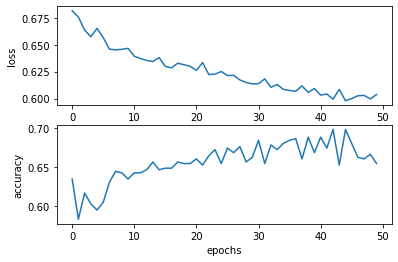

In [39]:
hist1 = train(model1, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=32, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 2

**Hipotesis:** La arquitectura de unicamente una capa oculta con 64 neuronas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 75 epochs, con un batch size de 64 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/75
16/16 [==============================] - 1s 43ms/step - loss: 0.6908 - accuracy: 0.5655 - val_loss: 0.6872 - val_accuracy: 0.5813
Epoch 2/75
16/16 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5546 - val_loss: 0.6806 - val_accuracy: 0.6488
Epoch 3/75
16/16 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.6220 - val_loss: 0.6769 - val_accuracy: 0.6052
Epoch 4/75
16/16 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6260 - val_loss: 0.6711 - val_accuracy: 0.6290
Epoch 5/75
16/16 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6359 - val_loss: 0.6682 - val_accuracy: 0.6111
Epoch 6/75
16/16 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6270 - val_loss: 0.6619 - val_accuracy: 0.6230
Epoch 7/75
16/16 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6379 - val_loss: 0.6569 - val_accuracy: 0.6290
Epoch 8/75
16/16 [=

16/16 [==============================] - 0s 3ms/step - loss: 0.5872 - accuracy: 0.7083 - val_loss: 0.5970 - val_accuracy: 0.6865
Epoch 60/75
16/16 [==============================] - 0s 3ms/step - loss: 0.5857 - accuracy: 0.6974 - val_loss: 0.5956 - val_accuracy: 0.6845
Epoch 61/75
16/16 [==============================] - 0s 3ms/step - loss: 0.5849 - accuracy: 0.7113 - val_loss: 0.5974 - val_accuracy: 0.6746
Epoch 62/75
16/16 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.7024 - val_loss: 0.5931 - val_accuracy: 0.6925
Epoch 63/75
16/16 [==============================] - 0s 3ms/step - loss: 0.5826 - accuracy: 0.7113 - val_loss: 0.5969 - val_accuracy: 0.6726
Epoch 64/75
16/16 [==============================] - 0s 3ms/step - loss: 0.5850 - accuracy: 0.6855 - val_loss: 0.5920 - val_accuracy: 0.6925
Epoch 65/75
16/16 [==============================] - 0s 3ms/step - loss: 0.5885 - accuracy: 0.6954 - val_loss: 0.5995 - val_accuracy: 0.6627
Epoch 66/75
16/16 [======

Text(0, 0.5, 'accuracy')

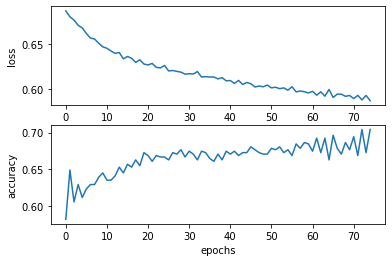

In [41]:
hist2 = train(model1, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=64, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=75, 
              description='dense64relu_dense1sigmoid_adam')

losses, accs = hist2['val_loss'], hist2['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 3

**Hipotesis:** La arquitectura de unicamente una capa oculta con 64 neuronas activadas por la funcion relu proveeran una exactitud superior al 90% tras entrenar durante 75 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/75
5/5 [==============================] - 1s 52ms/step - loss: 0.4805 - accuracy: 0.7678 - val_loss: 0.5117 - val_accuracy: 0.7593
Epoch 2/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4762 - accuracy: 0.7760 - val_loss: 0.5078 - val_accuracy: 0.7742
Epoch 3/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4761 - accuracy: 0.7760 - val_loss: 0.5084 - val_accuracy: 0.7643
Epoch 4/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4745 - accuracy: 0.7736 - val_loss: 0.5106 - val_accuracy: 0.7618
Epoch 5/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4748 - accuracy: 0.7719 - val_loss: 0.5090 - val_accuracy: 0.7643
Epoch 6/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4748 - accuracy: 0.7736 - val_loss: 0.5078 - val_accuracy: 0.7618
Epoch 7/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4743 - accuracy: 0.7736 - val_loss: 0.5089 - val_accuracy: 0.7593
Epoch 8/75
5/5 [=================

Epoch 60/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4708 - accuracy: 0.7760 - val_loss: 0.5066 - val_accuracy: 0.7618
Epoch 61/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4696 - accuracy: 0.7752 - val_loss: 0.5085 - val_accuracy: 0.7593
Epoch 62/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4701 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7568
Epoch 63/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4696 - accuracy: 0.7736 - val_loss: 0.5070 - val_accuracy: 0.7618
Epoch 64/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4698 - accuracy: 0.7744 - val_loss: 0.5068 - val_accuracy: 0.7618
Epoch 65/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4693 - accuracy: 0.7727 - val_loss: 0.5084 - val_accuracy: 0.7593
Epoch 66/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4695 - accuracy: 0.7744 - val_loss: 0.5080 - val_accuracy: 0.7618
Epoch 67/75
5/5 [==========

Text(0, 0.5, 'accuracy')

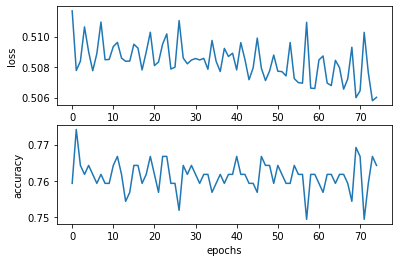

In [52]:
hist2 = train(model1, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=256, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=75, 
              description='dense64relu_dense1sigmoid_adam')

losses, accs = hist2['val_loss'], hist2['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 2

In [44]:
model2 = Sequential()
model2.add(Dense(32, input_dim=12, activation='tanh', kernel_initializer='uniform'))
model2.add(Dense(16, input_dim=12, activation='tanh', kernel_initializer='uniform'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                416       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


### Experimento 4

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 32 neuronas, la segunda compuesta por 16 neuronas, ambas activadas por la funcion tanh proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 32 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
32/32 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.4950 - val_loss: 0.6892 - val_accuracy: 0.6052
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5853 - val_loss: 0.6833 - val_accuracy: 0.5496
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5992 - val_loss: 0.6608 - val_accuracy: 0.6190
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6131 - val_loss: 0.6502 - val_accuracy: 0.6171
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.6250 - val_loss: 0.6432 - val_accuracy: 0.6190
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.6319 - val_loss: 0.6410 - val_accuracy: 0.6409
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.6548 - val_loss: 0.6469 - val_accuracy: 0.6389
Epoch 8/50
32/32 [==

Text(0, 0.5, 'accuracy')

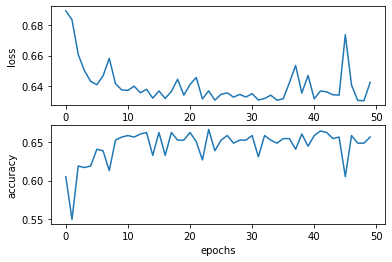

In [43]:
hist1 = train(model2, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=32, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense32tanh_dense16tanh_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 5

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 32 neuronas, la segunda compuesta por 16 neuronas, ambas activadas por la funcion tanh proveeran una exactitud superior al 80% tras entrenar durante 50 epochs, con un batch size de 128 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
8/8 [==============================] - 1s 23ms/step - loss: 0.6929 - accuracy: 0.5040 - val_loss: 0.6929 - val_accuracy: 0.4782
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5714 - val_loss: 0.6897 - val_accuracy: 0.6131
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.6101 - val_loss: 0.6874 - val_accuracy: 0.5952
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.6161 - val_loss: 0.6835 - val_accuracy: 0.6012
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6141 - val_loss: 0.6776 - val_accuracy: 0.6329
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6754 - accuracy: 0.6081 - val_loss: 0.6734 - val_accuracy: 0.5873
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6678 - accuracy: 0.6230 - val_loss: 0.6640 - val_accuracy: 0.6369
Epoch 8/50
8/8 [=================

Text(0, 0.5, 'accuracy')

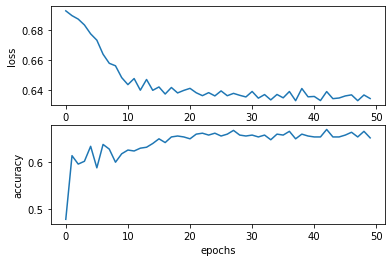

In [45]:
hist1 = train(model2, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=128, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense32tanh_dense16tanh_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 3

In [48]:
model3 = Sequential()
model3.add(Dense(64, input_dim=12, activation='relu', kernel_initializer='uniform'))
model3.add(Dense(32, activation='relu', kernel_initializer='uniform'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


### Experimento 6

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 64 neuronas, la segunda compuesta por 32 neuronas, ambas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 32 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
38/38 [==============================] - 1s 5ms/step - loss: 0.5284 - accuracy: 0.7397 - val_loss: 0.5471 - val_accuracy: 0.7072
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.7463 - val_loss: 0.5409 - val_accuracy: 0.7270
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7421 - val_loss: 0.5370 - val_accuracy: 0.7295
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7413 - val_loss: 0.5363 - val_accuracy: 0.7171
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5162 - accuracy: 0.7479 - val_loss: 0.5412 - val_accuracy: 0.7246
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.7488 - val_loss: 0.5332 - val_accuracy: 0.7345
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.7446 - val_loss: 0.5349 - val_accuracy: 0.7196
Epoch 8/50
38/38 [==

Text(0, 0.5, 'accuracy')

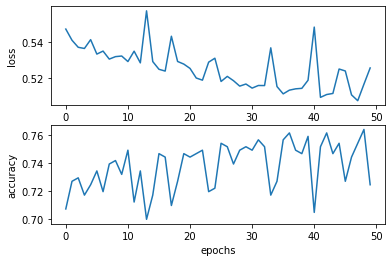

In [55]:
hist1 = train(model3, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=32, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 7

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 64 neuronas, la segunda compuesta por 32 neuronas, ambas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 128 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
10/10 [==============================] - 1s 20ms/step - loss: 0.4719 - accuracy: 0.7826 - val_loss: 0.5217 - val_accuracy: 0.7295
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4703 - accuracy: 0.7777 - val_loss: 0.5078 - val_accuracy: 0.7519
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4642 - accuracy: 0.7884 - val_loss: 0.5084 - val_accuracy: 0.7519
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4637 - accuracy: 0.7785 - val_loss: 0.5130 - val_accuracy: 0.7444
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4651 - accuracy: 0.7694 - val_loss: 0.5159 - val_accuracy: 0.7444
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4653 - accuracy: 0.7818 - val_loss: 0.5084 - val_accuracy: 0.7469
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.7860 - val_loss: 0.5090 - val_accuracy: 0.7469
Epoch 8/50
10/10 [=

Text(0, 0.5, 'accuracy')

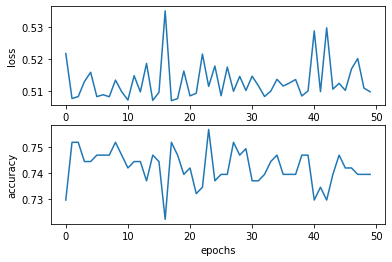

In [56]:
hist1 = train(model3, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=128, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 8

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 64 neuronas, la segunda compuesta por 32 neuronas, ambas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
5/5 [==============================] - 1s 41ms/step - loss: 0.4508 - accuracy: 0.7917 - val_loss: 0.5154 - val_accuracy: 0.7419
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4475 - accuracy: 0.7926 - val_loss: 0.5096 - val_accuracy: 0.7444
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4429 - accuracy: 0.7967 - val_loss: 0.5141 - val_accuracy: 0.7494
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4429 - accuracy: 0.7917 - val_loss: 0.5097 - val_accuracy: 0.7444
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4412 - accuracy: 0.7934 - val_loss: 0.5135 - val_accuracy: 0.7519
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4420 - accuracy: 0.7950 - val_loss: 0.5101 - val_accuracy: 0.7419
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4424 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7494
Epoch 8/50
5/5 [=================

Text(0, 0.5, 'accuracy')

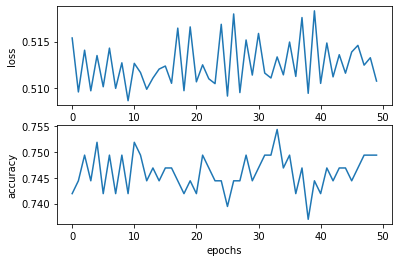

In [57]:
hist1 = train(model3, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=256, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 4

In [46]:
init = tf.keras.initializers.GlorotNormal(seed=None)
model4 = Sequential()
model4.add(Dense(128, input_dim=12, activation='relu', kernel_initializer=init))
model4.add(BatchNormalization())
model4.add(Dense(64, activation='relu', kernel_initializer=init))
model4.add(BatchNormalization())
model4.add(Dense(32, activation='relu', kernel_initializer=init))
model4.add(Dropout(0.1))
model4.add(Dense(1, activation='sigmoid'))
model4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

### Experimento 9

**Hipotesis:** La arquitectura descrita a continuacion tras entrenar durante 175 epochs, con un batch size de 1000 observaciones, utilizando el optimizador adamax y la funcion de costo binary crossentropy proveeran una exactitud superior al 80% .

Epoch 1/175
2/2 [==============================] - 1s 193ms/step - loss: 0.8014 - accuracy: 0.4782 - val_loss: 0.6903 - val_accuracy: 0.5417
Epoch 2/175
2/2 [==============================] - 0s 22ms/step - loss: 0.7363 - accuracy: 0.5556 - val_loss: 0.6902 - val_accuracy: 0.5496
Epoch 3/175
2/2 [==============================] - 0s 23ms/step - loss: 0.7055 - accuracy: 0.5724 - val_loss: 0.6903 - val_accuracy: 0.5437
Epoch 4/175
2/2 [==============================] - 0s 22ms/step - loss: 0.6968 - accuracy: 0.5754 - val_loss: 0.6905 - val_accuracy: 0.5357
Epoch 5/175
2/2 [==============================] - 0s 30ms/step - loss: 0.6809 - accuracy: 0.6101 - val_loss: 0.6908 - val_accuracy: 0.5536
Epoch 6/175
2/2 [==============================] - 0s 23ms/step - loss: 0.6718 - accuracy: 0.6161 - val_loss: 0.6911 - val_accuracy: 0.5833
Epoch 7/175
2/2 [==============================] - 0s 25ms/step - loss: 0.6707 - accuracy: 0.6210 - val_loss: 0.6912 - val_accuracy: 0.5933
Epoch 8/175
2/2 [==

2/2 [==============================] - 0s 24ms/step - loss: 0.5666 - accuracy: 0.7123 - val_loss: 0.6750 - val_accuracy: 0.5595
Epoch 60/175
2/2 [==============================] - 0s 23ms/step - loss: 0.5732 - accuracy: 0.7183 - val_loss: 0.6747 - val_accuracy: 0.5595
Epoch 61/175
2/2 [==============================] - 0s 25ms/step - loss: 0.5754 - accuracy: 0.7272 - val_loss: 0.6745 - val_accuracy: 0.5595
Epoch 62/175
2/2 [==============================] - 0s 24ms/step - loss: 0.5724 - accuracy: 0.7083 - val_loss: 0.6743 - val_accuracy: 0.5575
Epoch 63/175
2/2 [==============================] - 0s 22ms/step - loss: 0.5714 - accuracy: 0.7262 - val_loss: 0.6741 - val_accuracy: 0.5595
Epoch 64/175
2/2 [==============================] - 0s 23ms/step - loss: 0.5705 - accuracy: 0.7262 - val_loss: 0.6738 - val_accuracy: 0.5575
Epoch 65/175
2/2 [==============================] - 0s 25ms/step - loss: 0.5711 - accuracy: 0.7093 - val_loss: 0.6736 - val_accuracy: 0.5536
Epoch 66/175
2/2 [========

2/2 [==============================] - 0s 25ms/step - loss: 0.5382 - accuracy: 0.7341 - val_loss: 0.6519 - val_accuracy: 0.6230
Epoch 118/175
2/2 [==============================] - 0s 25ms/step - loss: 0.5374 - accuracy: 0.7371 - val_loss: 0.6514 - val_accuracy: 0.6270
Epoch 119/175
2/2 [==============================] - 0s 24ms/step - loss: 0.5356 - accuracy: 0.7440 - val_loss: 0.6510 - val_accuracy: 0.6270
Epoch 120/175
2/2 [==============================] - 0s 24ms/step - loss: 0.5346 - accuracy: 0.7341 - val_loss: 0.6505 - val_accuracy: 0.6270
Epoch 121/175
2/2 [==============================] - 0s 23ms/step - loss: 0.5397 - accuracy: 0.7361 - val_loss: 0.6501 - val_accuracy: 0.6250
Epoch 122/175
2/2 [==============================] - 0s 26ms/step - loss: 0.5362 - accuracy: 0.7282 - val_loss: 0.6496 - val_accuracy: 0.6250
Epoch 123/175
2/2 [==============================] - 0s 26ms/step - loss: 0.5277 - accuracy: 0.7371 - val_loss: 0.6490 - val_accuracy: 0.6290
Epoch 124/175
2/2 [=

Epoch 175/175
2/2 [==============================] - 0s 22ms/step - loss: 0.5183 - accuracy: 0.7510 - val_loss: 0.6232 - val_accuracy: 0.6548
Done!


Text(0, 0.5, 'accuracy')

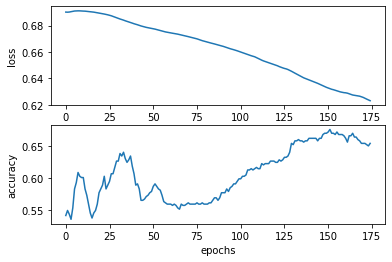

In [47]:
hist1 = train(model4, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=1000, 
              optimizer='adamax', 
              loss_fn='binary_crossentropy', 
              epochs=175, 
              description='dense128relu_dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

## Conclusiones

Los resultados de las experimentaciones anteriores mostraron que el predecir el gusto de un agente basado en las caracteristicas de sus canciones (con like y sin like) es posible por medio de una red neuronal vanilla, esto hasta cierto nivel ya que agregamos y sacrificamos un poco de nuestra metrica de evaluacion la exactitud con la razon de no sobre ajustar el modelo a la relativa pequena cantidad de canciones disponibles para nuestro agente. 

Con el ultimo experimento (el mejor) se logro tener una exactitud del 80% sobre el set de validacion mostrado a continuacion. Bajo la arquitectura ganadora descrita a continuacion: 
* 3 capas ocultas, 1 capa con 128 neuronas, la segunda compuesta por 64 neuronas y 32 neuronas en la tercera, ambas activadas por la funcion relu .
* 2 capas de normalizacion del output continuas a las salidas de las capas densas
* 1 capa de dropout para castigar el sobre ajuste al desactivar el 10% de las salidas de la ultima capa oculta
Se logro disminuir el error a 0.14, teniendo una exactitud del 92% en el entrenamiento y de 80% en el set de validacion, si nos damos la variacion entre estos resultados no es grande, pero tampoco es pequena es decir que al incluir la capa de dropout agregamos ruido que nos ayudo a generalizar un poco mejor, esto se demuestra mucho mas con los resultados de los experimentos anteriores donde ambos resultados no cambiaban.

Ahora ya con 80% de exactitud podemos concluir que el modelo puede tomar canciones aleatorias y clasificarlas para ser mostradas o no hacia el agente, en teoria el 80% de las canciones mostradas o recomendadas deberian de ser aceptadas o queridas por el agente.

#### Validation

Para la validacion se utilizara el mejor modelo obtenido por la experimentacion anterior, el mejor modelo es el de la arquitectura numero 4.

In [170]:
loss, acc = model4.evaluate(x_validation, y_validation, verbose=None)
print(f"VALIDATION ACCURACY: {acc}")

VALIDATION ACCURACY: 0.8035714030265808


#### librerias

In [1]:
from tensorflow.keras.layers     import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics             import classification_report
from sklearn.model_selection     import train_test_split
from tensorflow.keras            import Sequential

import matplotlib.pyplot as plt
import tensorflow        as tf
import pandas            as pd
import numpy             as np
import os 
import cv2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Parte 2

La detección temprana de enfermedades en los ojos es crucial para conseguir una visión duradera a través de los años, es por esto que para esta parte se desarrolló una Red Convolución Neuronal la cual nos permitirá clasificar entre 5 tipos de enfermedades en los ojos, esto basado en imágenes médicas de la retina.


### Pre processing

In [19]:
label_to_one_hot = {'DR': np.array([1,0,0,0,0]),
                    'ARMD': np.array([0,1,0,0,0]),
                    'DN': np.array([0,0,1,0,0]),
                    'MH': np.array([0,0,0,1,0]),
                    'MYA': np.array([0,0,0,1,0])
                   }
x = []
y = []

def resize_img(img):
    return cv2.resize(img, (200, 200))

def rotate_img(img):
    return cv2.rotate(img, cv2.ROTATE_180), cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

def translate_img(img):
    src_points = np.float32([[0,0], [200-1,0], [0,200-1]])
    dst_points = np.float32([[200-1,0], [0,0], [200-1,200-1]])
    matrix = cv2.getAffineTransform(src_points, dst_points)
    return cv2.warpAffine(img, matrix, (200,200))

def perspective_img(img):
    src_points = np.float32([[0,0], [200-1,0], [0,200-1], [200-1, 200-1]])
    dst_points = np.float32([[0,0], [200-1,0], [int(0.33*200),200-1], [int(0.66*200), 200-1]])
    projective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    return cv2.warpPerspective(img, projective_matrix, (200,200))


for sett in ['train', 'test']:
    for label in os.listdir(f'parte2/project_new/{sett}'):
        for temp in os.listdir(f'parte2/project_new/{sett}/{label}'):
            temp_img = resize_img(cv2.imread(f'parte2/project_new/{sett}/{label}/{temp}'))
            rotated = rotate_img(temp_img)
            translated = translate_img(temp_img)
            pers = perspective_img(temp_img)
            x.append(temp_img)
            x.append(rotated[0])
            x.append(rotated[1])
            x.append(rotated[2])
            x.append(translated)
            x.append(pers)
            y.append(label_to_one_hot[label])
            y.append(label_to_one_hot[label])
            y.append(label_to_one_hot[label])
            y.append(label_to_one_hot[label])
            y.append(label_to_one_hot[label])
            y.append(label_to_one_hot[label])
                        
x = np.array(x)
y = np.array(y)

np.save('parte2/project_new/augmented_data/x.npy',x)
np.save('parte2/project_new/augmented_data/y.npy', y)

In [2]:
x = np.load('parte2/project_new/augmented_data/x.npy')
y = np.load('parte2/project_new/augmented_data/y.npy')

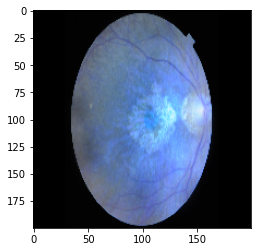

In [3]:
plt.imshow(x[0])

In [3]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, x_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((3085, 200, 200, 3),
 (1029, 200, 200, 3),
 (1028, 200, 200, 3),
 (3085, 5),
 (1029, 5),
 (1028, 5))

## Experimentacion

In [4]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'/parte2/experiments/{description}_batch={batch_size}_epochs={epochs}/'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=1, save_weights_only=1, mode='max')
    history = model.fit(train[0], train[1], validation_data=(test[0], test[1]), epochs=epochs, callbacks=[checkpoint_callback], verbose=1)
    
    print("Done!")
    return history.history['val_loss'], history.history['val_accuracy']

### Arquitectura 1

In [6]:
init = tf.keras.initializers.GlorotNormal(seed=None)
model1 = Sequential()
model1.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu', kernel_initializer=init))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(units=32, activation='relu', kernel_initializer=init))
model1.add(Dense(units=5, activation='sigmoid'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Experimento 1

**Hipotesis:** La arquitectura de unicamente una capa convolucional con 16 filtros de 3x3, 1 capa oculta con 32 neuronas, ambas capas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y la funcion de costo categorical crossentropy.

Epoch 1/50
97/97 [==============================] - 5s 45ms/step - loss: 350.6372 - accuracy: 0.4117 - val_loss: 34.0512 - val_accuracy: 0.4373
Epoch 2/50
97/97 [==============================] - 4s 42ms/step - loss: 11.1612 - accuracy: 0.5102 - val_loss: 4.0969 - val_accuracy: 0.5248
Epoch 3/50
97/97 [==============================] - 4s 41ms/step - loss: 2.6876 - accuracy: 0.5520 - val_loss: 3.2695 - val_accuracy: 0.5199
Epoch 4/50
97/97 [==============================] - 4s 42ms/step - loss: 2.5402 - accuracy: 0.5433 - val_loss: 3.0902 - val_accuracy: 0.5374
Epoch 5/50
97/97 [==============================] - 4s 42ms/step - loss: 1.8454 - accuracy: 0.5793 - val_loss: 2.5494 - val_accuracy: 0.5190
Epoch 6/50
97/97 [==============================] - 4s 43ms/step - loss: 1.6532 - accuracy: 0.5912 - val_loss: 2.3249 - val_accuracy: 0.5267
Epoch 7/50
97/97 [==============================] - 4s 42ms/step - loss: 1.5071 - accuracy: 0.6071 - val_loss: 2.2997 - val_accuracy: 0.5326
Epoch 8/5

Text(0, 0.5, 'accuracy')

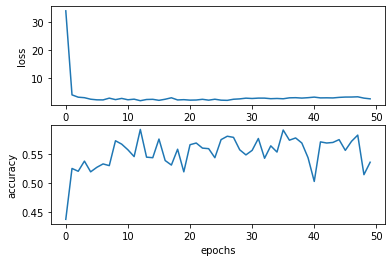

In [34]:
losses, accs = train(model1, [x_train, y_train], [x_test, y_test], 256, 'adam', 'categorical_crossentropy', 50, 'conv32k3relu_conv16k3_relu_flatten_dense32reli_dense5sigmoid')
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 2

**Hipotesis:** La arquitectura de unicamente una capa convolucional con 16 fltros de 3x3, 1 capa oculta con 32 neuronas, ambas capas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 25 epochs, con un batch size de 512 observaciones, utilizando el optimizador adam y la funcion de costo categorical crossentropy.

Epoch 1/25
97/97 [==============================] - 8s 45ms/step - loss: 151.9298 - accuracy: 0.3634 - val_loss: 1.5668 - val_accuracy: 0.3703
Epoch 2/25
97/97 [==============================] - 4s 41ms/step - loss: 1.5420 - accuracy: 0.3715 - val_loss: 1.5170 - val_accuracy: 0.3703
Epoch 3/25
97/97 [==============================] - 6s 59ms/step - loss: 1.4957 - accuracy: 0.3715 - val_loss: 1.4740 - val_accuracy: 0.3703
Epoch 4/25
97/97 [==============================] - 4s 39ms/step - loss: 1.4564 - accuracy: 0.3715 - val_loss: 1.4376 - val_accuracy: 0.3703
Epoch 5/25
97/97 [==============================] - 4s 40ms/step - loss: 1.4236 - accuracy: 0.3715 - val_loss: 1.4076 - val_accuracy: 0.3703
Epoch 6/25
97/97 [==============================] - 4s 40ms/step - loss: 1.3965 - accuracy: 0.3598 - val_loss: 1.3831 - val_accuracy: 0.3703
Epoch 7/25
97/97 [==============================] - 4s 41ms/step - loss: 1.3742 - accuracy: 0.3968 - val_loss: 1.3629 - val_accuracy: 0.4052
Epoch 8/25


Text(0, 0.5, 'accuracy')

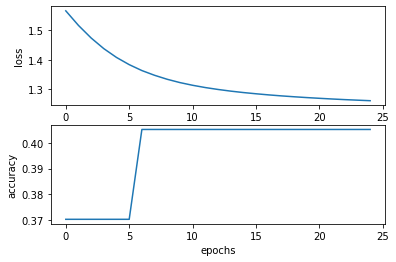

In [7]:
losses, accs = train(model1, [x_train, y_train], [x_test, y_test], 512, 'adam', 'categorical_crossentropy', 25, 'conv32k3relu_conv16k3_relu_flatten_dense32reli_dense5sigmoid')
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 2

In [9]:
init = tf.keras.initializers.GlorotNormal(seed=None)
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(200, 200, 3), activation='relu', kernel_initializer=init))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(units=32, activation='relu', kernel_initializer=init))
model2.add(BatchNormalization())
model2.add(Dense(units=32, activation='relu', kernel_initializer=init))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(units=5, activation='sigmoid'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Experimento 3

**Hipotesis:** La arquitectura de unicamente una capa convolucional con 16 filtros de 3x3, 1 capa de maxpooling de 2x2 y 2 capas densas con 32 neuronas, ambas capas activadas por la funcion relu y normalizadas por una capa de Batch normalization seguido de 1 capa de dropout al 40% proveeran una exactitud superior al 85% tras entrenar durante 50 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y la funcion de costo categorical crossentropy.

Epoch 1/50
97/97 [==============================] - 6s 52ms/step - loss: 1.7222 - accuracy: 0.3984 - val_loss: 2.7778 - val_accuracy: 0.3664
Epoch 2/50
97/97 [==============================] - 5s 47ms/step - loss: 1.3678 - accuracy: 0.5015 - val_loss: 1.1422 - val_accuracy: 0.5617
Epoch 3/50
97/97 [==============================] - 5s 47ms/step - loss: 1.2053 - accuracy: 0.5504 - val_loss: 1.1597 - val_accuracy: 0.5510
Epoch 4/50
97/97 [==============================] - 5s 47ms/step - loss: 1.1412 - accuracy: 0.5767 - val_loss: 2.2534 - val_accuracy: 0.5151
Epoch 5/50
97/97 [==============================] - 5s 47ms/step - loss: 1.0652 - accuracy: 0.5890 - val_loss: 0.9336 - val_accuracy: 0.6511
Epoch 6/50
97/97 [==============================] - 5s 47ms/step - loss: 1.0172 - accuracy: 0.6078 - val_loss: 0.9583 - val_accuracy: 0.6463
Epoch 7/50
97/97 [==============================] - 5s 47ms/step - loss: 0.9759 - accuracy: 0.6285 - val_loss: 0.8525 - val_accuracy: 0.6910
Epoch 8/50
97

Text(0, 0.5, 'accuracy')

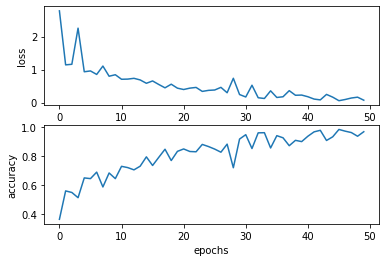

In [11]:
losses, accs = train(model2, [x_train, y_train], [x_test, y_test], 256, 'adam', 'categorical_crossentropy', 50, 'conv32k3relu_conv16k3_relu_flatten_dense32reli_dense5sigmoid')
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Conclusiones

### Validacion

In [12]:
loss, acc = model2.evaluate(x_validation, y_validation, verbose=None)
print(f"VALIDATION ACCURACY: {acc}")

VALIDATION ACCURACY: 0.9659532904624939


Para validar la generalización del modelo se evaluó este en un set de datos antes no vistos, en el cual alcanzó una exactitud de 96%, es decir que la clasificación de las 5 enfermedades antes mencionadas es una tarea confiable al utilizar este modelo. La arquitectura responsable de este resultado está descrita a continuación:
* 1 capa convolucional con 16 filtros de 3x3 activada por relu, 1 capa de maxpooling con filtro de 2x2
* 2 capas densas de 32 neuronas activadas por relu, estas capas seguidas de capas de normalización
* 1 capa de Dropout al 10%.
* 1 capa densa de 5 neuronas activada por función sigmoid

#### prueba de validacion

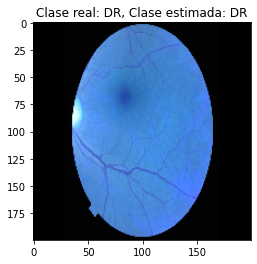

In [13]:
random_evaluation = np.random.randint(0, len(x_validation)-1)
index_to_label = {0: 'DR',
                  1: 'ARMD',
                  2: 'DN',
                  3: 'MH',
                  4: 'MYA'}

x_val = x_validation[random_evaluation]
y_real = y_validation[random_evaluation]
y_pred = model2.predict(x_val.reshape((-1, 200,200,3)))
plt.imshow(x_val)
plt.title(f"Clase real: {index_to_label[np.argmax(y_real)]}, Clase estimada: {index_to_label[np.argmax(y_pred)]}")
plt.show()

#### Conclusiones

## Parte 3

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

La prediccion del precio de las criptomonedas es un tema de interes en estos dias debido a su relevante oportunidad de sacar beneficio del trading. Para esta parte utilizaremos una Red Neuronal Recurente para asi poder estimar el precio del bitcoin en el tiempo. Para lograr esto, alimentaremos a nuestro modelo con observaciones que estan compuestas por el precio de cierre de Bitcoin en los ultimos 5 dias pasados y la idea es poder predecir el precio de cierre el dia siguiente. 

#### Dataset

In [55]:
raw = pd.read_csv("./parte3/data/data.csv")
dataset = raw[['Date', 'Close']].rename(columns={'Close': 'Price'})
dataset['Date'] = dataset['Date'].apply(lambda x: str(x)[:10])

### Bitcoin en los ultimos 50 dias

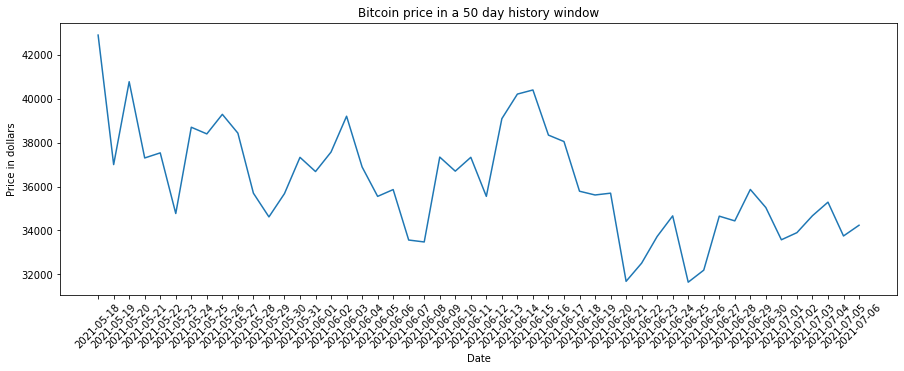

In [56]:
window = 50
plt.figure(figsize=(15, 5))
plt.plot(dataset['Date'][-window:], dataset['Price'][-window:])
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.xticks(rotation=45)
plt.title(f'Bitcoin price in a {window} day history window')
plt.show()

### Precio Historico de Bitcoin

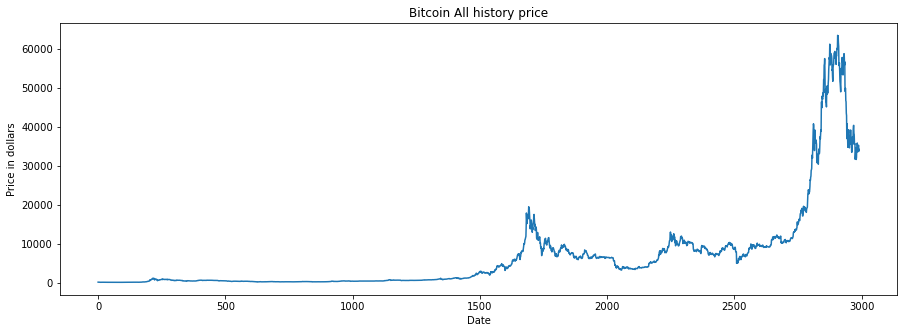

In [57]:
plt.figure(figsize=(15, 5))
plt.plot(dataset['Price'])
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.title(f'Bitcoin All history price')
plt.show()

### Pre procesamiento de data

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset['Price'] = scaler.fit_transform(dataset[['Price']])

x_window = 5
y_window = 1
x = []
y = []

for x_w in range(0, len(dataset['Price']) - x_window - y_window - 1, x_window + y_window):
    x.append(dataset['Price'][x_w: x_w + x_window])
    y.append(dataset['Price'][x_w + x_window: x_w + x_window + y_window])
    
x, y = np.array(x), np.array(y)
x = x.reshape((x.shape[0], 1, x_window))
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, shuffle = False, stratify = None)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, shuffle = False, stratify = None)

In [59]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'./parte3/experiments/{description}_batch={batch_size}_epochs={epochs}'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=1, save_weights_only=1, mode='max')
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    x_train, y_train = train[0], train[1]
    x_test, y_test = test[0], test[1]
    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback])
    
    print("Done!")
    return history

## Experimentacion

### Arquitectura 1

In [69]:
model = Sequential()
model.add(LSTM(5, input_shape=(1, x_window)))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

### Experimento 1

**Hipotesis:** La arquitectura de una capa LSTM de 5 neuronas, 2 capas densas con activacion relu seguidas de capas de castigo dropout al 10% proveeran almenos una disminucion en el RMSE por debajo de 0.5 tras entrenar por 100 epochs, con un batch size de 128 observaciones, utilizando el optimizador adam y MSE como funcion de error.

Epoch 1/100
3/3 [==============================] - 4s 374ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0039 - val_root_mean_s

3/3 [==============================] - 0s 13ms/step - loss: 2.0096e-04 - root_mean_squared_error: 0.0142 - val_loss: 1.1369e-04 - val_root_mean_squared_error: 0.0107
Epoch 48/100
3/3 [==============================] - 0s 12ms/step - loss: 1.5807e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.3673e-04 - val_root_mean_squared_error: 0.0117
Epoch 49/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2658e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.0641e-04 - val_root_mean_squared_error: 0.0103
Epoch 50/100
3/3 [==============================] - 0s 13ms/step - loss: 1.5145e-04 - root_mean_squared_error: 0.0123 - val_loss: 8.5511e-05 - val_root_mean_squared_error: 0.0092
Epoch 51/100
3/3 [==============================] - 0s 14ms/step - loss: 1.9411e-04 - root_mean_squared_error: 0.0139 - val_loss: 8.6985e-05 - val_root_mean_squared_error: 0.0093
Epoch 52/100
3/3 [==============================] - 0s 14ms/step - loss: 1.9552e-04 - root_mean_squared_error: 0.0140 

Epoch 93/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2979e-04 - root_mean_squared_error: 0.0114 - val_loss: 8.4284e-05 - val_root_mean_squared_error: 0.0092
Epoch 94/100
3/3 [==============================] - 0s 14ms/step - loss: 1.5899e-04 - root_mean_squared_error: 0.0126 - val_loss: 7.4658e-05 - val_root_mean_squared_error: 0.0086
Epoch 95/100
3/3 [==============================] - 0s 13ms/step - loss: 9.2722e-05 - root_mean_squared_error: 0.0096 - val_loss: 7.6379e-05 - val_root_mean_squared_error: 0.0087
Epoch 96/100
3/3 [==============================] - 0s 14ms/step - loss: 1.3551e-04 - root_mean_squared_error: 0.0116 - val_loss: 7.3729e-05 - val_root_mean_squared_error: 0.0086
Epoch 97/100
3/3 [==============================] - 0s 14ms/step - loss: 9.9039e-05 - root_mean_squared_error: 0.0100 - val_loss: 7.2156e-05 - val_root_mean_squared_error: 0.0085
Epoch 98/100
3/3 [==============================] - 0s 14ms/step - loss: 1.6988e-04 - root_mean_squared_e

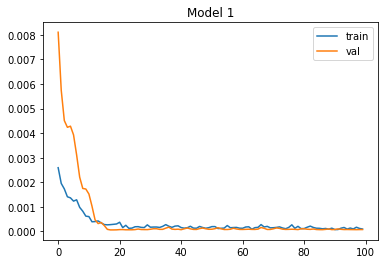

In [20]:
model1_hist = train(model, [x_train, y_train], [x_test, y_test], 128, 'adam', 'mean_squared_error', 100, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model1_hist.history['loss'], label='train')
plt.plot(model1_hist.history['val_loss'], label='val')
plt.title('Model 1')
plt.legend()
plt.show()

### Experimento 2

**Hipotesis:** La arquitectura de una capa LSTM de 5 neuronas, 2 capas densas con activacion relu seguidas de capas de castigo dropout al 10% proveeran almenos una disminucion en el RMSE por debajo de 0.001 tras entrenar por 50 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y MSE como funcion de error.

In [63]:
model1_hist.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

Epoch 1/50
2/2 [==============================] - 3s 1s/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 2/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 4/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0892
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0066 - val_root_mean_squared_er

2/2 [==============================] - 0s 24ms/step - loss: 3.1489e-04 - root_mean_squared_error: 0.0177 - val_loss: 9.3450e-05 - val_root_mean_squared_error: 0.0097
Epoch 49/50
2/2 [==============================] - 0s 29ms/step - loss: 2.4541e-04 - root_mean_squared_error: 0.0157 - val_loss: 9.2130e-05 - val_root_mean_squared_error: 0.0096
Epoch 50/50
2/2 [==============================] - 0s 29ms/step - loss: 3.4378e-04 - root_mean_squared_error: 0.0185 - val_loss: 9.2094e-05 - val_root_mean_squared_error: 0.0096
Done!


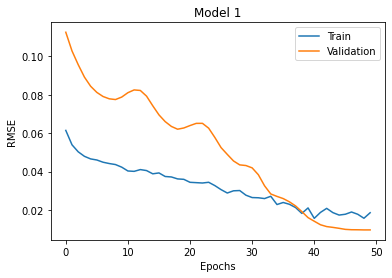

In [70]:
model1_hist = train(model, [x_train, y_train], [x_test, y_test], 256, 'adam', 'mean_squared_error', 50, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model1_hist.history['root_mean_squared_error'], label='Train')
plt.plot(model1_hist.history['val_root_mean_squared_error'], label='Validation')
plt.title('Model 1')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Experimento 3

**Hipotesis:** La arquitectura de una capa LSTM de 5 neuronas, 2 capas densas con activacion relu seguidas de capas de castigo dropout al 10% proveeran almenos una disminucion en el RMSE por debajo de 0.0.001 tras entrenar por 100 epochs, con un batch size de 64 observaciones, utilizando el optimizador adam y MSE como funcion de error.

In [53]:
model1_hist = train(model, [x_train, y_train], [x_test, y_test], 64, 'adam', 'mean_squared_error', 50, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model1_hist.history['loss'], label='train')
plt.plot(model1_hist.history['val_loss'], label='val')
plt.title('Model 1')
plt.legend()
plt.show()

Epoch 1/50


ValueError: in user code:

    C:\Users\Ricar\anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Ricar\anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Ricar\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Ricar\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Ricar\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Ricar\anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Ricar\anaconda3\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\Ricar\anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Ricar\anaconda3\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_12 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)


### Arquitectura 2

In [73]:
model2 = Sequential()
model2.add(LSTM(5, input_shape=(1, x_window)))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='linear'))

### Experimento 4

**Hipotesis:** La arquitectura de una capa LSTM de 5 neuronas, 2 capas densas con activacion relu seguidas de 1 unica capa de castigo dropout al 20% proveeran almenos una disminucion en el RMSE por debajo de 0.05 tras entrenar por 50 epochs, con un batch size de 64 observaciones, utilizando el optimizador adam y MSE como funcion de error.

Epoch 1/50
5/5 [==============================] - 3s 157ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0699
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 8.3853e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0023 - val_root_mean_squared_

Epoch 48/50
5/5 [==============================] - 0s 9ms/step - loss: 1.3935e-04 - root_mean_squared_error: 0.0118 - val_loss: 5.6600e-05 - val_root_mean_squared_error: 0.0075
Epoch 49/50
5/5 [==============================] - 0s 8ms/step - loss: 1.5345e-04 - root_mean_squared_error: 0.0124 - val_loss: 6.4414e-05 - val_root_mean_squared_error: 0.0080
Epoch 50/50
5/5 [==============================] - 0s 8ms/step - loss: 2.2209e-04 - root_mean_squared_error: 0.0149 - val_loss: 7.6380e-05 - val_root_mean_squared_error: 0.0087
Done!


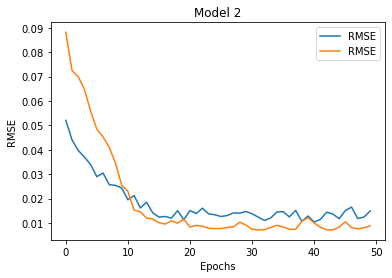

In [72]:
model2_hist = train(model2, [x_train, y_train], [x_test, y_test], 64, 'adam', 'mean_squared_error', 50, 'lstm5_dense32relu_dense16relu_dropout2_denselinear')
plt.plot(model2_hist.history['root_mean_squared_error'], label='RMSE')
plt.plot(model2_hist.history['val_root_mean_squared_error'], label='RMSE')
plt.title('Model 2')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Experimento 5

**Hipotesis:** La arquitectura de una capa LSTM de 5 neuronas, 2 capas densas con activacion relu seguidas de 1 unica capa de castigo dropout al 20% proveeran almenos una disminucion en el RMSE por debajo de 0.005 tras entrenar por 100 epochs, con un batch size de 64 observaciones, utilizando el optimizador adam y MSE como funcion de error.

Epoch 1/100
5/5 [==============================] - 3s 131ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0031 - val_root_mean_square

5/5 [==============================] - 0s 8ms/step - loss: 2.1176e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.2025e-05 - val_root_mean_squared_error: 0.0072
Epoch 48/100
5/5 [==============================] - 0s 8ms/step - loss: 1.2491e-04 - root_mean_squared_error: 0.0112 - val_loss: 9.7474e-05 - val_root_mean_squared_error: 0.0099
Epoch 49/100
5/5 [==============================] - 0s 7ms/step - loss: 2.0266e-04 - root_mean_squared_error: 0.0142 - val_loss: 7.0677e-05 - val_root_mean_squared_error: 0.0084
Epoch 50/100
5/5 [==============================] - 0s 7ms/step - loss: 1.1050e-04 - root_mean_squared_error: 0.0105 - val_loss: 5.3501e-05 - val_root_mean_squared_error: 0.0073
Epoch 51/100
5/5 [==============================] - 0s 7ms/step - loss: 2.0298e-04 - root_mean_squared_error: 0.0142 - val_loss: 6.0234e-05 - val_root_mean_squared_error: 0.0078
Epoch 52/100
5/5 [==============================] - 0s 7ms/step - loss: 1.0121e-04 - root_mean_squared_error: 0.0101 - val_

5/5 [==============================] - 0s 7ms/step - loss: 1.3603e-04 - root_mean_squared_error: 0.0117 - val_loss: 7.0904e-05 - val_root_mean_squared_error: 0.0084
Epoch 94/100
5/5 [==============================] - 0s 8ms/step - loss: 1.2446e-04 - root_mean_squared_error: 0.0112 - val_loss: 5.3095e-05 - val_root_mean_squared_error: 0.0073
Epoch 95/100
5/5 [==============================] - 0s 8ms/step - loss: 9.8099e-05 - root_mean_squared_error: 0.0099 - val_loss: 6.7995e-05 - val_root_mean_squared_error: 0.0082
Epoch 96/100
5/5 [==============================] - 0s 8ms/step - loss: 1.1764e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.1487e-04 - val_root_mean_squared_error: 0.0107
Epoch 97/100
5/5 [==============================] - 0s 8ms/step - loss: 1.1483e-04 - root_mean_squared_error: 0.0107 - val_loss: 6.4283e-05 - val_root_mean_squared_error: 0.0080
Epoch 98/100
5/5 [==============================] - 0s 8ms/step - loss: 1.5509e-04 - root_mean_squared_error: 0.0125 - val_

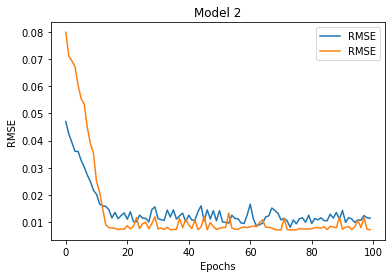

In [74]:
model2_hist = train(model2, [x_train, y_train], [x_test, y_test], 64, 'adam', 'mean_squared_error', 100, 'lstm5_dense32relu_dense16relu_dropout2_denselinear')
plt.plot(model2_hist.history['root_mean_squared_error'], label='RMSE')
plt.plot(model2_hist.history['val_root_mean_squared_error'], label='RMSE')
plt.title('Model 2')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## Conclusiones

El precio del bitcoin es algo que depende de muchos factores externos, por lo que tratarlo de predecir como una serie de tiempo ajena a factores externos talvez no es una buena idea, pero a pesar de que su comportamiento como en la primera grafica muestra un comiezo algo pronunciado alzista, en los ultimos tiempos bitcoin ha tenido un comportamiento algo desordenado en el que no se parece en nada a su historia, en cualquier dia puede dar un moviemiento muy brusco y lo que realmente interesaria ver es en que posicion queda su precio al final del dia. Creo que lo mas importante para inversores es poder tener una idea de en donde terminara el precio al final del dia, cosa que por su comportamiento se ve algo dificil pero lo que si nos da es la certeza de si sera alcista o no el precio final lo que al final es una buena primera senal en si invertir o no.

A continuacion se muestra una grafica del modelo con data de validacion es decir que el modelo nunca habia visto y es interesante como al principio bajo un comportamiento algo normal se comporta bien el modelo, pero cuando se llega a los puntos donde es algo desordenado no logra llegar a predecir el precio exacto, pero si el comportamiento. 

Este resultado se obtuvo de entrenar el modelo2 al entrenar al modelo con ventanas de 5 dias hacia atras y tratando de predecir unicamente un dia adelante, el error se redujo hasta llegar a una estacionalidad en donde ya no disminuia el error solamente oscilaba en un minimo de RMSE de 0.0011.

### Validation

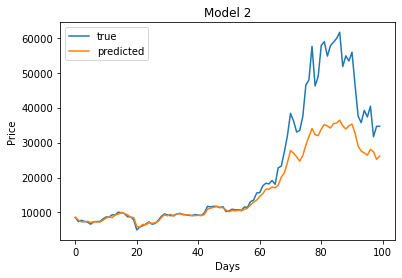

In [76]:
test_predictions = scaler.inverse_transform(model2.predict(x_validation))
plt.plot(scaler.inverse_transform(y_validation), label='true')
plt.plot(test_predictions, label='predicted')
plt.title('Model 2')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()